# Gillespie rate inference using SBI (Simulation Based Inference)

In [26]:
# Imports
import sbi.utils as utils
from sbi.inference.base import infer
import numpy as np
import torch

import matplotlib.pyplot as plt

import tellurium as te

## Lotka Volterra

### Define Simulator

In [17]:
# Define simulator
def lv_simulator(propose_rates):

    t = 0.
    stop_time = 5000. # Length of sim
    s = torch.tensor([20., 40.]) # Starting points
    path = np.insert(s, 0, t, axis=0).reshape(1, 3)

    ## Hazard functions
    rate_functions = [lambda s: propose_rates[0] * s[0],
                      lambda s: propose_rates[1] * s[1] * s[0],
                      lambda s: propose_rates[2] * s[1]]
    n_func = len(rate_functions)

    transition_matrix = torch.tensor([[1, 0], [-1, 1], [0, -1]])

    # Run sim until time limit is reached
    while True:

        sampling_weights = [f(s) for f in rate_functions]
        total_weight = sum(sampling_weights)

        # Sample a rate
        probs = np.array([weight / total_weight for weight in sampling_weights])
        sample = np.random.choice(n_func, p=probs)
        t += np.random.exponential(1.0 / total_weight)

        if t >= stop_time:
            break

        # Update species
        s = s + transition_matrix[sample]

        # Add some noise to outputs
        s = torch.normal(s, .25)
        s[0] = max(1, s[0])
        s[1] = max(1, s[1])

        path = torch.cat((path, np.insert(s, 0, t, axis=0).reshape(1, 3)), axis=0)

    path = torch.cat((path, np.insert(s, 0, stop_time, axis = 0).reshape(1, 3)), axis=0)
    path = torch.flatten(path)

    # Mask values onto long tensor so that all samples are of equal length
    mask_len = 10000 - len(path)
    mask = torch.tensor([-1 for _ in range(mask_len)])
    path = torch.cat((path, mask), 0)

    return path[3:]

### Define Prior

In [18]:
# Choose a prior
prior = utils.BoxUniform(
    low=torch.tensor([0.0005, 0.0001, 0.0005]),
    high=torch.tensor([0.005, 0.0005, 0.005])
)

# Only uniform prior implemented into sbi package currently
# Easy to add more manually, for example log normal
# prior = utils.LogNormalPrior(
#     torch.tensor([np.log(.0015),
#                   np.log(.0002),
#                   np.log(.003)]), .25)

### Run inference

Currently only SNPE and SNLE run without error. SNRE has issues with masked values at end of simulation (-1).

In [19]:
# Train model
num_sim = 500
method = 'SNPE' #SNPE or SNLE or SNRE
posterior = infer(
    lv_simulator,
    prior,
    method=method,
    num_workers=-1,
    num_simulations=num_sim
)

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

In [22]:
# Sample some observations with known ground truth
obs = torch.tensor([lv_simulator([0.001, 0.0002, 0.003]).numpy() for _ in range(10)])

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

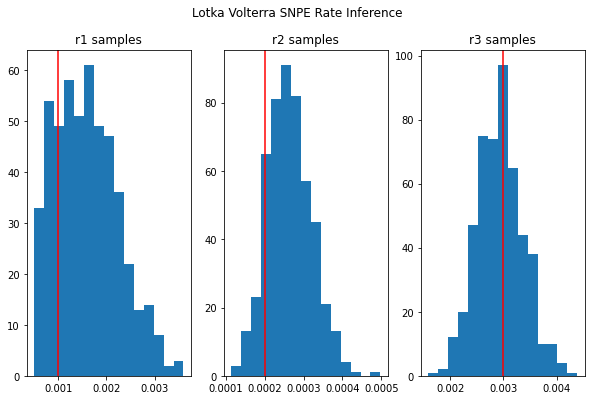

In [24]:
# sample the posterior and plot results
samples = posterior.sample((500,), x=obs[0]) # SNPE only works with one obs, SNLE will work with more

fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].hist(samples[:, 0].numpy(), bins=15)
ax[1].hist(samples[:, 1].numpy(), bins=15)
ax[2].hist(samples[:, 2].numpy(), bins=15)
ax[0].axvline(x = .001, color = "red")
ax[1].axvline(x = .0002, color = "red")
ax[2].axvline(x = .003, color = "red")

ax[0].set_title("r1 samples")
ax[1].set_title("r2 samples")
ax[2].set_title("r3 samples")

plt.suptitle("Lotka Volterra SNPE Rate Inference")
plt.show()

SNLE has a fairly tight posterior but is usually biased compared to the ground truth rates. This may be due to a low dimensional input (3) but high dimensional output (10000)? SNPE usually contains the true rate but is A. biased towards what observation is passed and B. has a much wider posterior than SNLE.

## Lac Operon

Used https://github.com/vivarium-collective/vivarium-notebooks/blob/main/notebooks/Lac_Operon_CRN.ipynb to build lac operon model.

### Print Model Details

In [27]:
## Use Tellurium to print model details
ant_lo = te.sbmlToAntimony(r"../data/LacOperon/LacOperon_stochastic.xml")
model_lo = te.loadSBMLModel(r"../data/LacOperon/LacOperon_stochastic.xml")

In [28]:
print(ant_lo)

// Created by libAntimony v2.12.0
model *biocrnpyler_24259()

  // Compartments and Species:
  compartment default;
  species rna_M in default, monomer_betaGal in default, protein_betaGal in default;
  species Lactose_external in default, Lactose_internal in default, Glucose_external in default;
  species Glucose_internal in default, protein_Lactose_Permease in default;
  species dna_Lac_Operon in default, Biomass in default, Lactose_consumed in default;

  // Reactions:
  r0: dna_Lac_Operon => dna_Lac_Operon + rna_M; dna_Lac_Operon*r0_Vtx*(r0_k_leak + (Lactose_internal^r0_n_L/(r0_K_L^r0_n_L + Lactose_internal^r0_n_L))*(1/(1 + (Glucose_external/r0_K_G)^r0_n_G)));
  r1: rna_M => rna_M + monomer_betaGal; k_tl_beta_Gal__*rna_M;
  r2: rna_M => rna_M + protein_Lactose_Permease; k_tl_lacP__*rna_M;
  r3: 4 monomer_betaGal => protein_betaGal; BGal_tetramerization__*monomer_betaGal*(monomer_betaGal - 1)*(monomer_betaGal - 2)*(monomer_betaGal - 3);
  r4: Lactose_internal => Lactose_consumed; BGa

In [33]:
## Transistion matrix
model_lo.getFullStoichiometryMatrix()

                            r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10
rna_M                    [[  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,   0],
monomer_betaGal           [  0,  1,  0, -4,  0,  0,  0,  0,  0,  0,   0],
protein_betaGal           [  0,  0,  0,  1,  0,  0,  0,  0,  0, -1,   0],
Lactose_external          [  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,   0],
Lactose_internal          [  0,  0,  0,  0, -1,  0,  1, -1,  0,  0,   0],
Glucose_external          [  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,   0],
Glucose_internal          [  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,   0],
protein_Lactose_Permease  [  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  -1],
dna_Lac_Operon            [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0],
Biomass                   [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0],
Lactose_consumed          [  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,   0]]

### Define Simulator

In [34]:
rate_names = ['k_tl_beta_Gal__',
    'k_tl_lacP__',
    'BGal_tetramerization__',
    'BGal_vmax__',
    'Bgal_Kd__',
    'GluPermease_vmax__',
    'GluPermease_Kd__',
    'LacPermease_reverse_vmax__',
    'LacPermease_Kd__',
    'kdeg_mRNA__',
    'kdeg_prot__',
    'r0_Vtx',
    'r0_n_L',
    'r0_K_L',
    'r0_K_G',
    'r0_n_G',
    'r0_k_leak',
    'r4_n',
    'r5_n',
    'r6_GluPermease_Kd',
    'r6_LacPermease_vmax',
    'r6_LacPermease_Kd',
    'r6_phi_G',
    'r7_n']

In [128]:
# Define simulator
def lac_operon_simulator(propose_rates):

    t = 0.
    #stop_time = 10. # Length of sim
    # This would be faster without a dictionary
    s = {'rna_M' : 0., 'monomer_betaGal' : 0., 'protein_betaGal' : 0., 
         'Lactose_external' : 120440000., 'Lactose_internal' : 0., 'Glucose_external' : 60220000., 
         'Glucose_internal' : 0., 'protein_Lactose_Permease' : 0., 'dna_Lac_Operon' : 2., 'Biomass' : 1000., 
         'Lactose_consumed' : 0.} # Starting points
  
    path = np.insert(torch.tensor(np.fromiter(s.values(), dtype=float)), 0, t, axis=0).reshape(1, 12)

    ## Hazard functions
    rate_functions = [
        lambda s: s['dna_Lac_Operon']*propose_rates[11]*(propose_rates[16] + (s['Lactose_internal']**propose_rates[12]/(propose_rates[13]**propose_rates[12] + s['Lactose_internal']**propose_rates[12]))*(1/(1 + (s['Glucose_external']/propose_rates[14])**propose_rates[15]))),
        lambda s: propose_rates[0]*s['rna_M'],
        lambda s: propose_rates[1]*s['rna_M'],
        lambda s: propose_rates[2]*s['monomer_betaGal']*(s['monomer_betaGal'] - 1)*(s['monomer_betaGal'] - 2)*(s['monomer_betaGal'] - 3),
        lambda s: propose_rates[3]*s['protein_betaGal']*s['Lactose_internal']**propose_rates[17]/(propose_rates[4]**propose_rates[17] + s['Lactose_internal']**propose_rates[17]),
        lambda s: propose_rates[5]*s['Biomass']*s['Glucose_external']**propose_rates[18]/(propose_rates[6]**propose_rates[18] + s['Glucose_external']**propose_rates[18]),
        lambda s: (s['protein_Lactose_Permease']*propose_rates[20]*s['Lactose_external']/(s['Lactose_external'] + propose_rates[21]))*(1 - propose_rates[22]*s['Glucose_external']/(propose_rates[19] + s['Glucose_external'])),
        lambda s: propose_rates[7]*s['protein_Lactose_Permease']*s['Lactose_internal']**propose_rates[23]/(propose_rates[8]**propose_rates[23] + s['Lactose_internal']**propose_rates[23]),
        lambda s: propose_rates[9]*s['rna_M'],
        lambda s: propose_rates[10]*s['protein_betaGal'],
        lambda s: propose_rates[10]*s['protein_Lactose_Permease']
    ]
    
    n_func = len(rate_functions)

    transition_matrix = torch.tensor([[  1,  0,  0,  0,  0,  0,  0,  0, -1,  0,   0],
                                    [  0,  1,  0, -4,  0,  0,  0,  0,  0,  0,   0],
                                    [  0,  0,  0,  1,  0,  0,  0,  0,  0, -1,   0],
                                    [  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,   0],
                                    [  0,  0,  0,  0, -1,  0,  1, -1,  0,  0,   0],
                                    [  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,   0],
                                    [  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,   0],
                                    [  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  -1],
                                    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0],
                                    [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,   0],
                                    [  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,   0]])

    # Run sim until time limit is reached
    # while True:
    ## Just loop for x iterations
    for i in range(10000):

        sampling_weights = [f(s) for f in rate_functions]
        total_weight = sum(sampling_weights)

        # Sample a rate
        probs = np.array([weight / total_weight for weight in sampling_weights])
        sample = np.random.choice(n_func, p=probs)
        t += np.random.exponential(1.0 / sampling_weights[sample])
        
        # if t >= stop_time:
        #     break

        # Update species
        new_vals = torch.tensor(np.fromiter(s.values(), dtype=float)) + transition_matrix[1]
        
        # Update dictionary with new values
        s = {list(s.keys())[i] : new_vals[i].item() for i in range(len(new_vals))}

        # Add some noise to outputs
        # s = torch.normal(s, .25)

        path = torch.cat((path, np.insert(new_vals, 0, t, axis=0).reshape(1, 12)), axis=0)

    # path = torch.cat((path, np.insert(new_vals, 0, stop_time, axis = 0).reshape(1, 12)), axis=0)
    path = torch.flatten(path)

    # Mask values onto long tensor so that all samples are of equal length
    # mask_len = 100000 - len(path)
    # mask = torch.tensor([-1 for _ in range(mask_len)])
    # path = torch.cat((path, mask), 0)

    return path[12:]

In [129]:
# Make sure sim runs
test = lac_operon_simulator([0.156666666666667, 0.313333333333333, 1000., 300., 84310., 301., 
                      9033., 1.18966666666667, 8800000., 0.00783333333333333, 
                      0.000166666666666667, 0.003, 4., 2900000., 1506., 2., 0.05, 
                      1., 1., 9033., 35.8, 156576, 0.35, 1.])

### Define Prior

In [138]:
# Choose a prior
prior = utils.BoxUniform(
    low=torch.tensor([0.1, 0.1, 999., 299., 84309., 300., 
                      9032, 1., 8799999., 0.005, 
                      0.0002, 0.002, 3., 2899999., 1500., 1., 0.04, 
                      .75, .75, 9032., 35., 156575, 0.3, .75]),
    high=torch.tensor([0.2, 0.5, 1001., 301., 84311., 302., 
                      9034., 1.5, 8800001., 0.009, 
                      0.0001, 0.004, 5., 2900001., 1510., 3., 0.06, 
                      1.25, 1.25, 9034., 36.5, 156577, 0.4, 1.25])
)

# Only uniform prior implemented into sbi package currently
# Easy to add more manually, for example log normal
# prior = utils.LogNormalPrior(
#     torch.tensor([np.log(.0015),
#                   np.log(.0002),
#                   np.log(.003)]), .25)

### Run Inference

In [142]:
# Train model
num_sim = 200
method = 'SNLE' #SNPE or SNLE or SNRE
posterior = infer(
    lac_operon_simulator,
    prior,
    method=method,
    num_workers=-1,
    num_simulations=num_sim
)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 20 epochs.

In [140]:
# Sample some observations with known ground truth
obs = torch.tensor([lac_operon_simulator([0.156666666666667, 0.313333333333333, 1000., 300., 84310., 301., 
                      9033., 1.18966666666667, 8800000., 0.00783333333333333, 
                      0.000166666666666667, 0.003, 4., 2900000., 1506., 2., 0.05, 
                      1., 1., 9033., 35.8, 156576, 0.35, 1.]).numpy() for _ in range(5)])

In [143]:
# sample the posterior
samples = posterior.sample((200,), x=obs[0]) # SNPE only works with one obs, SNLE will work with more

KeyboardInterrupt: 

In [ ]:
# plot results
true_rates = [0.156666666666667, 0.313333333333333, 1000., 300., 84310., 301., 
              9033., 1.18966666666667, 8800000., 0.00783333333333333, 
              0.000166666666666667, 0.003, 4., 2900000., 1506., 2., 0.05, 
              1., 1., 9033., 35.8, 156576, 0.35, 1.]

fig, ax = plt.subplots(10,2, figsize = (10,8))

group = 0
for i in range(10):
    ax[i,0].hist(samples[:, group].numpy(), bins = 15)
    ax[i,1].hist(samples[:, group+1].numpy(), bins = 15)
    
    ax[i,0].axvline(true_rates[group], color = "red", linewidth=2)
    ax[i,1].axvline(true_rates[group+1], color = "red", linewidth=2)
    
    group += 2

plt.suptitle("Lac Operon SNLE Rate Inference")
plt.show()